In [2]:
from pydrake.all import (LinearQuadraticRegulator, MathematicalProgram, Variables,
                         Solve, RealContinuousLyapunovEquation, Polynomial, MosekSolver)
import control
import sympy as sp

from pydrake.examples.acrobot import (AcrobotGeometry, AcrobotInput,
                                      AcrobotPlant, AcrobotState, AcrobotParams)
from pydrake.all import Linearize, LinearQuadraticRegulator, SymbolicVectorSystem, Variable, Saturation, \
WrapToSystem, Simulator, Polynomial

from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput

from IPython.display import SVG, display
import pydot
import numpy as np
import math
import control

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import pydrake.forwarddiff as pf
import time

from IPython.display import display, Math, Markdown
from pydrake.examples.pendulum import PendulumPlant
from pydrake.examples.acrobot import AcrobotPlant
from pydrake.all import MultibodyPlant, Parser, SinCos, MakeVectorVariable, ToLatex, Substitute, Box
from underactuated import FindResource
from underactuated.scenarios import AddShape

from pydrake.all import (Jacobian, MathematicalProgram, Polynomial,
                         RegionOfAttraction, RegionOfAttractionOptions, Solve,
                         SymbolicVectorSystem, ToLatex, Variable, Variables,
                         plot_sublevelset_expression, AddMultibodyPlantSceneGraph, SolverOptions, 
                         CommonSolverOption)

from pydrake.solvers.mosek import MosekSolver
import sympy as sp
from sympy.physics.vector import dynamicsymbols as dynamicsymbols

from pydrake.all import (LinearQuadraticRegulator, MathematicalProgram, Variables,
                         Solve, RealContinuousLyapunovEquation)

from pydrake.examples.pendulum import PendulumParams
from pydrake.systems.controllers import LinearQuadraticRegulator
import scipy

## Simple 1D Example

We want to find the ROA for <br>
$$\begin{aligned} \dot{x} = \frac{x^3-x}{1+x^2} \end{aligned}$$ <br>

We first linearize it to find E = 1, A = -1, and use this with the linear Lyapunov equation to find $P$

In [9]:
P = control.lyap([-1], [1], E = [1])

We now do the SOS program. While it is possible to do the multiplications involving $\dot{M}$ directly in drake, we first show it in sympy and then manually code it in. These are for the $x^T\dot{M}^TPMx$ and $x^TM^TP\dot{M}x$ terms in $\dot{V}$. 

In [12]:
x = sp.symbols('x')
M = 1 + x**2
Mdot = 2*x*((x**3-x)/(1+x**2))
P = 1
x*M*P*Mdot*x

2*x**3*(x**3 - x)

In [13]:
prog = MathematicalProgram()
x = prog.NewIndeterminates(1, 'x')

M = 1 + x[0]**2

Mdot = 2*x[0]*((x[0]**3 - x[0])/(1 + x[0]**2))

f = x[0]**3 - x[0]

P = 0.5

V = x*M*P*M*x
Vdot = f*P*M*x + 2*x[0]**3*(x[0]**3 - x[0]) + 2*x[0]**3*(x[0]**3 - x[0]) + x*M*P*f

V = Polynomial(V[0])
Vdot = Polynomial(Vdot[0])

lambda_, _ = prog.NewSosPolynomial(Variables(x), 6)

rho = prog.NewContinuousVariables(1, 'rho')[0]
d = 3
prog.AddSosConstraint(Polynomial(x.dot(x))**d * (V - rho) - lambda_*Vdot)
#prog.AddSosConstraint(-Vdot + lambda_*(V - rho))

prog.AddCost(-rho)

solver = MosekSolver()
result = solver.Solve(prog)

assert result.is_success()


/tmp/ipykernel_39027/1753003516.py:12: RuntimeWarning: invalid value encountered in multiply
  V = x*M*P*M*x
/tmp/ipykernel_39027/1753003516.py:13: RuntimeWarning: invalid value encountered in multiply
  Vdot = f*P*M*x + 2*x[0]**3*(x[0]**3 - x[0]) + 2*x[0]**3*(x[0]**3 - x[0]) + x*M*P*f
/tmp/ipykernel_39027/1753003516.py:13: RuntimeWarning: invalid value encountered in add
  Vdot = f*P*M*x + 2*x[0]**3*(x[0]**3 - x[0]) + 2*x[0]**3*(x[0]**3 - x[0]) + x*M*P*f


In [14]:
result.GetSolution(rho)

1.9999999611778172

## Pendulum Example in Implicit Form

In [12]:
p = PendulumParams()
b = p.damping()
m = p.mass()
l = p.length()
g = p.gravity()

The state is $x = [s, c, \dot{\theta}]$

In [13]:
# write the dynamics as Exdot = Ax + Bu
A = np.zeros([3, 3])
A[0,2] = -1
A[2,0] = -m*g*l
A[2,2] = -b

E = np.eye(3)
E[2,2] = m*l**2

B = np.zeros([3, 1])
B[2,0] = 1

F = np.zeros([1, 3])
F[0, 1] = -2

Find matrix $P_{proj}$ such that its rows form an orthonormal basis for the kernel of F

In [14]:
P_proj = scipy.linalg.null_space(F)
P_proj = P_proj.T

In [15]:
# LQR costs
Q = np.diag([10, 10, 1])
R = [1]

In [16]:
X, L, G = control.care(P_proj@A@P_proj.T, P_proj@B, P_proj@Q@P_proj.T, R, E = P_proj@E@P_proj.T)
X = P_proj.T@X@P_proj
controller = B.T@X@E

/tmp/ipykernel_3919/1930163689.py:11: RuntimeWarning: invalid value encountered in sin
  u_old = K[0]*np.sin(t) + K[1]*np.cos(t) + K[2]*td
/tmp/ipykernel_3919/1930163689.py:11: RuntimeWarning: invalid value encountered in cos
  u_old = K[0]*np.sin(t) + K[1]*np.cos(t) + K[2]*td
/tmp/ipykernel_3919/1930163689.py:11: RuntimeWarning: invalid value encountered in multiply
  u_old = K[0]*np.sin(t) + K[1]*np.cos(t) + K[2]*td


<IPython.core.display.Javascript object>


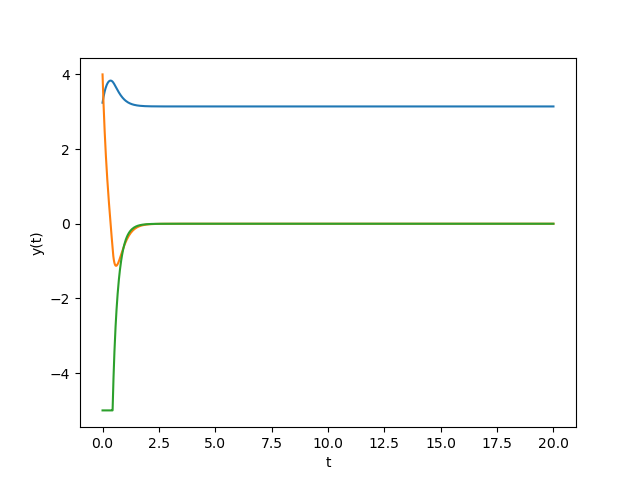

In [17]:
#before moving further, confirm that implicitly found dynamics work in simulation
def UprightState():
    return np.array([np.pi, 0])

t = Variable("t")
td = Variable("td")
garbage = Variable("garbage")

K = controller[0]
x = np.hstack([t, td])
u_old = K[0]*np.sin(t) + K[1]*np.cos(t) + K[2]*td
u_old = -u_old

own_controller = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=[u_old])

# dv_0 = td
# dv_1 = (-b*td - mass*gravity*length*pydrake.forwarddiff.sin(t) + u)/(mass*length**2)

# x_dot = np.array([dv_0, dv_1])

# continuous_vector_system = SymbolicVectorSystem(state=x, dynamics=x_dot, output=x)

def acrobot_balancing_example():

    builder = DiagramBuilder()
    pendulum = builder.AddSystem(PendulumPlant())
    
    saturation = builder.AddSystem(Saturation(min_value=[-5], max_value=[5]))
    builder.Connect(saturation.get_output_port(0), pendulum.get_input_port(0))
    wrapangles = WrapToSystem(2)
    wrapangles.set_interval(0, 0, 2. * np.pi)
    wrapto = builder.AddSystem(wrapangles)
    builder.Connect(pendulum.get_output_port(0), wrapto.get_input_port(0))
    controller = builder.AddSystem(own_controller)
    builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))
    
    logger = LogVectorOutput(wrapto.get_output_port(0), builder)
    logger2 = LogVectorOutput(saturation.get_output_port(0), builder)
    
    diagram = builder.Build()
    
    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # Simulate
    simulator.set_target_realtime_rate(0.0)
    duration = 20
    for i in range(1):
        context.SetTime(0.)
        np.random.seed(10000)
#         context.SetContinuousState(np.append(UprightState(), 0) -
#                                  1.4* np.random.randn(3,))
        context.SetContinuousState(np.array([np.pi+0.1, 4, 0]))
        simulator.Initialize()
        simulator.AdvanceTo(duration)
        
        log = logger.FindLog(context)
        plt.figure()
        plt.plot(log.sample_times(), log.data().transpose())\
        
        log2 = logger2.FindLog(context)
        plt.plot(log2.sample_times(), log2.data().transpose())
        plt.xlabel('t')
        plt.ylabel('y(t)');
    

acrobot_balancing_example()

In [18]:
# get closed loop A for linear Lyapunov
A_cloop = A - B@controller

In [19]:
# solve projected linear Lyapunov and then project back
P = control.lyap((P_proj@A_cloop@P_proj.T).T, np.eye(2), E = (P_proj@E@P_proj.T).T)
P = P_proj.T@P@P_proj

In [20]:
# check positive definiteness 
prog = MathematicalProgram()

x = prog.NewIndeterminates(3, 'x')
x0 = np.array([0, -1, 0])
I = np.eye(3)

V = (x-x0).T@E.T@P@E@(x-x0) + (x-x0).T@E.T@I@E@(x-x0) # extra term added to make it positive definite
V = Polynomial(V)

trig = Polynomial(x[0]**2 + x[1]**2 - 1)
lambda_s = prog.NewFreePolynomial(Variables(x), 2)

eps = 1e-5
prog.AddSosConstraint(V - eps*Polynomial((x-x0).dot(x-x0)) + lambda_s*trig)

solver = MosekSolver()
result = solver.Solve(prog)

assert result.is_success()

/tmp/ipykernel_3919/265650160.py:8: RuntimeWarning: invalid value encountered in subtract
  V = (x-x0).T@E.T@P@E@(x-x0) + (x-x0).T@E.T@I@E@(x-x0)
/tmp/ipykernel_3919/265650160.py:8: RuntimeWarning: invalid value encountered in matmul
  V = (x-x0).T@E.T@P@E@(x-x0) + (x-x0).T@E.T@I@E@(x-x0)
/tmp/ipykernel_3919/265650160.py:15: RuntimeWarning: invalid value encountered in subtract
  prog.AddSosConstraint(V - eps*Polynomial((x-x0).dot(x-x0)) + lambda_s*trig)


In [21]:
# certify without any limits
prog = MathematicalProgram()

x = prog.NewIndeterminates(3, 'x')
x0 = np.array([0, -1, 0])

f1 = x[1]*x[2]
f2 = -x[0]*x[2]
f3 = -b*x[2] - m*g*l*x[0] - K@(x-x0)

rho = prog.NewContinuousVariables(1, 'rho')[0]

f = np.hstack([f1, f2, f3])

V = (x-x0).T@E.T@(P+I)@E@(x-x0)
Vdot = f.T@(P+I)@E@(x-x0) + (x-x0).T@E.T@(P+I)@f
#Vdot = (x-x0).T@A_cloop.T@P@E@(x-x0) + (x-x0).T@E.T@P@A_cloop@(x-x0)

V = Polynomial(V)
Vdot = Polynomial(Vdot)

lambda_ = prog.NewSosPolynomial(Variables(x), 2)[0]
lambda_s = prog.NewFreePolynomial(Variables(x), 2)

trig = Polynomial(x[0]**2 + x[1]**2 - 1)

# prog.AddSosConstraint(-Vdot - eps*Polynomial((x-x0)@(x-x0))+ lambda_*(V - rho) + lambda_s*(trig))
prog.AddSosConstraint(Polynomial((x-x0)@(x-x0))*(V - rho) - lambda_*Vdot + lambda_s*trig)

prog.AddCost(-rho)

solver = MosekSolver()
result = solver.Solve(prog)

assert result.is_success()

/tmp/ipykernel_3919/3278088648.py:9: RuntimeWarning: invalid value encountered in subtract
  f3 = -b*x[2] - m*g*l*x[0] - K@(x-x0)
/tmp/ipykernel_3919/3278088648.py:9: RuntimeWarning: invalid value encountered in matmul
  f3 = -b*x[2] - m*g*l*x[0] - K@(x-x0)
/tmp/ipykernel_3919/3278088648.py:15: RuntimeWarning: invalid value encountered in subtract
  V = (x-x0).T@E.T@(P+I)@E@(x-x0)
/tmp/ipykernel_3919/3278088648.py:15: RuntimeWarning: invalid value encountered in matmul
  V = (x-x0).T@E.T@(P+I)@E@(x-x0)
/tmp/ipykernel_3919/3278088648.py:16: RuntimeWarning: invalid value encountered in matmul
  Vdot = f.T@(P+I)@E@(x-x0) + (x-x0).T@E.T@(P+I)@f
/tmp/ipykernel_3919/3278088648.py:16: RuntimeWarning: invalid value encountered in subtract
  Vdot = f.T@(P+I)@E@(x-x0) + (x-x0).T@E.T@(P+I)@f
/tmp/ipykernel_3919/3278088648.py:28: RuntimeWarning: invalid value encountered in subtract
  prog.AddSosConstraint(Polynomial((x-x0)@(x-x0))*(V - rho) - lambda_*Vdot + lambda_s*trig)
/tmp/ipykernel_3919/3278

In [22]:
print(result.GetSolution(rho))

2.777367089869795


In [23]:
# certify with a torque limit
prog = MathematicalProgram()

x = prog.NewIndeterminates(3, 'x')
x0 = np.array([0, -1, 0])

u_min = -5
u = -K@(x-x0)
u = u

f1 = x[1]*x[2]
f2 = -x[0]*x[2]
f3 = -b*x[2] - m*g*l*x[0] - u_min

rho = prog.NewContinuousVariables(1, 'rho')[0]

f = np.hstack([f1, f2, f3])

V = (x-x0).T@E.T@(P+I)@E@(x-x0)
Vdot = f.T@(P+I)@E@(x-x0) + (x-x0).T@E.T@(P+I)@f
#Vdot = (x-x0).T@A_cloop.T@P@E@(x-x0) + (x-x0).T@E.T@P@A_cloop@(x-x0)

V = Polynomial(V)
Vdot = Polynomial(Vdot)

lambda_ = prog.NewSosPolynomial(Variables(x), 2)[0]
lambda_s = prog.NewFreePolynomial(Variables(x), 2)
lambda_u,_ = prog.NewSosPolynomial(Variables(x), 2)

trig = Polynomial(x[0]**2 + x[1]**2 - 1)

# prog.AddSosConstraint(-Vdot - eps*Polynomial((x-x0)@(x-x0))+ lambda_*(V - rho) + lambda_s*(trig))
prog.AddSosConstraint(Polynomial((x-x0)@(x-x0))*(V - rho) - lambda_*Vdot + lambda_s*trig\
                      +lambda_u*Polynomial(u-u_min))

prog.AddCost(-rho)

solver = MosekSolver()
result = solver.Solve(prog)

assert result.is_success()

/tmp/ipykernel_3919/2367092185.py:8: RuntimeWarning: invalid value encountered in subtract
  u = -K@(x-x0)
/tmp/ipykernel_3919/2367092185.py:8: RuntimeWarning: invalid value encountered in matmul
  u = -K@(x-x0)
/tmp/ipykernel_3919/2367092185.py:19: RuntimeWarning: invalid value encountered in subtract
  V = (x-x0).T@E.T@(P+I)@E@(x-x0)
/tmp/ipykernel_3919/2367092185.py:19: RuntimeWarning: invalid value encountered in matmul
  V = (x-x0).T@E.T@(P+I)@E@(x-x0)
/tmp/ipykernel_3919/2367092185.py:20: RuntimeWarning: invalid value encountered in matmul
  Vdot = f.T@(P+I)@E@(x-x0) + (x-x0).T@E.T@(P+I)@f
/tmp/ipykernel_3919/2367092185.py:20: RuntimeWarning: invalid value encountered in subtract
  Vdot = f.T@(P+I)@E@(x-x0) + (x-x0).T@E.T@(P+I)@f
/tmp/ipykernel_3919/2367092185.py:33: RuntimeWarning: invalid value encountered in subtract
  prog.AddSosConstraint(Polynomial((x-x0)@(x-x0))*(V - rho) - lambda_*Vdot + lambda_s*trig\
/tmp/ipykernel_3919/2367092185.py:33: RuntimeWarning: invalid value en

In [24]:
print(result.GetSolution(rho))

0.26282860915047773


<IPython.core.display.Javascript object>


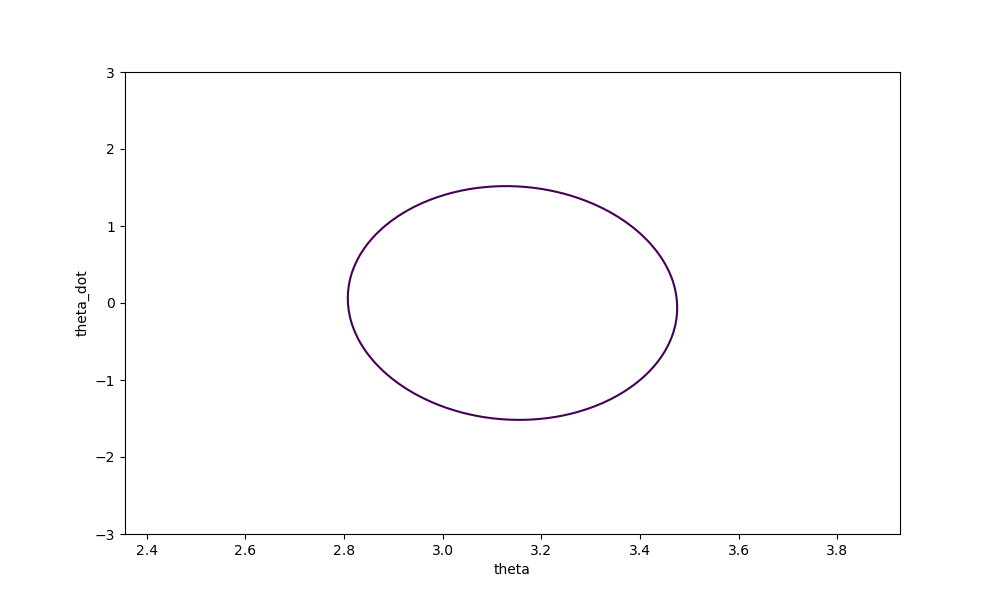

Text(0.5, 0, 'theta')

In [25]:
# plot the ROA
V_indeterminates = list(V.indeterminates())
# V_indeterminates

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
# img = ax.scatter(TR1[success_indices], XR1[success_indices], alpha=0.2)
# img = ax.scatter(TR1_old[success_indices_old], XR1_old[success_indices_old], alpha=0.02)

thetas = np.linspace(3*np.pi/4, 5*np.pi/4, 100)
theta_ds = np.linspace(-3, 3, 100)
theta, theta_d = np.meshgrid(thetas, theta_ds)

Vplot = np.zeros_like(theta)

env = {}
for i in range(len(theta)):
    for j in range(len(theta[i])): 
        env[V_indeterminates[0]] = np.sin(theta[i, j])
        env[V_indeterminates[1]] = np.cos(theta[i, j])
        env[V_indeterminates[2]] = theta_d[i, j]
        Vplot[i, j] = V.Evaluate(env)

# Vplot_old = np.zeros_like(TRV1)
# env_old = {}
# for i in range(len(TRV1)):
#     for j in range(len(TRV1[i])): 
#         env_old[V_old_indeterminates[0]] = XRV1[i, j]
#         env_old[V_old_indeterminates[1]] = TRV1[i, j] - np.pi
#         env_old[V_old_indeterminates[2]] = 0
#         env_old[V_old_indeterminates[3]] = 0
#         Vplot_old[i, j] = V_old.Evaluate(env_old)
        
ax.contour(theta,theta_d, Vplot, levels=[0.2626])
# ax.contour(TRV1,XRV1, Vplot_old, levels=[4005.9])
# ax.set_xlim(0, 2*np.pi)
# ax.set_ylim(-100, 100)
ax.set_ylabel("theta_dot")
ax.set_xlabel("theta")

## For the cartpole

In [26]:
mp = 0.1
mc = 10
l = 0.5
g = 9.8

In [27]:
E = np.eye(5)
E[3,3] = mc+mp
E[3,4] = -mp*l
E[4,3] = -mp*l
E[4,4] = mp*l**2

A = np.zeros([5,5])
A[0,3] = 1
A[1,4] = -1
A[4,1] = -mp*g*l

B = np.zeros([5,1])
B[3,0] = 1

F = np.zeros([1,5])
F[0,2] = -2

In [30]:
Q = np.diag([10, 10, 10, 1, 1])
R = [1]

In [31]:
P_proj = (scipy.linalg.null_space(F)).T

In [32]:
X, L, G = control.care(P_proj@A@P_proj.T, P_proj@B, P_proj@Q@P_proj.T, R, E = P_proj@E@P_proj.T)
P = P_proj.T@X@P_proj
K = B.T@P@E
K

array([[  -3.16227766, -236.64629347,    0.        ,   -9.47864457,
          53.23572985]])

In [33]:
# check positive definite v/s semi-definite
prog = MathematicalProgram()
x = prog.NewIndeterminates(5, 'X')
x0 = np.array([0, 0, -1, 0, 0])

M = np.eye(5, dtype='object')
M[3,3] = mc+mp
M[3,4] = mp*l*x[2]
M[4,3] = mp*l*x[2]
M[4,4] = mp*l**2

lambda_s = prog.NewFreePolynomial(Variables(x), 2)

eps = 1e-5

trig = Polynomial(x[1]**2 + x[2]**2 - 1)
I = np.eye(5)
V = (x-x0).T@M.T@(P+0.5*I)@M@(x-x0)
V = Polynomial(V)

prog.AddSosConstraint(V - eps*Polynomial((x-x0).dot(x-x0)) + lambda_s*trig)

solver = MosekSolver()
result = solver.Solve(prog)

print(str(result.get_solver_details().solution_status))

assert result.is_success()

1


/tmp/ipykernel_3919/2876586848.py:18: RuntimeWarning: invalid value encountered in subtract
  V = (x-x0).T@M.T@(P+0.5*I)@M@(x-x0)
/tmp/ipykernel_3919/2876586848.py:18: RuntimeWarning: invalid value encountered in matmul
  V = (x-x0).T@M.T@(P+0.5*I)@M@(x-x0)
/tmp/ipykernel_3919/2876586848.py:21: RuntimeWarning: invalid value encountered in subtract
  prog.AddSosConstraint(V - eps*Polynomial((x-x0).dot(x-x0)) + lambda_s*trig)


In [34]:
prog = MathematicalProgram()
x = prog.NewIndeterminates(5, 'X')
x0 = np.array([0, 0, -1, 0, 0])
y = P_proj@x
y0 = P_proj@x0

M = np.eye(5, dtype='object')
M[3,3] = mc+mp
M[3,4] = mp*l*x[2]
M[4,3] = mp*l*x[2]
M[4,4] = mp*l**2

My = P_proj@M@P_proj.T

Mdot = np.zeros([5,5], dtype='object')
Mdot[3,3] = 0
Mdot[3,4] = -mp*l*x[1]*x[4]
Mdot[4,3] = -mp*l*x[1]*x[4]
Mdot[4,4] = 0

Mdoty = P_proj@M@P_proj.T

f = np.zeros([5,1], dtype='object')
f[0,0] = x[3]
f[1,0] = x[2]*x[4]
f[2,0] = -x[1]*x[4]
f[3,0] = mp*l*x[4]**2*x[1] - (K@(x-x0))[0]
f[4,0] = -mp*g*l*x[1]

fy = P_proj@f
P_corr = P + 5000*I

V = (x-x0).T@M.T@P_corr@M@(x-x0)
Vdot = f.T@P_corr@M@(x-x0) + (x-x0).T@Mdot.T@P_corr@M@(x-x0) \
        + (x-x0).T@M.T@P_corr@Mdot@(x-x0) + (x-x0).T@M.T@P_corr@f

# V = y.T@My.T@X@My@y
# Vdot = fy.T@X@My@y + y.T@Mdoty.T@X@My@y + y.T@My.T@X@Mdoty@y + y.T@My.T@X@fy

V = Polynomial(V)
Vdot = Polynomial(Vdot[0])

trig = Polynomial(x[1]**2 + x[2]**2 - 1)

lambda_, lambda_Q = prog.NewSosPolynomial(Variables(x), 6)
lambda_s = prog.NewFreePolynomial(Variables(x), 8)

d = 3

rho = prog.NewContinuousVariables(1, 'rho')[0]
prog.AddSosConstraint(Polynomial(((x-x0).dot(x-x0))**d)*(V - rho) - lambda_*Vdot + lambda_s*trig)

# lambda_, lambda_Q = prog.NewSosPolynomial(Variables(x), 6)

# d = 4
# rho = prog.NewContinuousVariables(1, 'rho')[0]
# prog.AddSosConstraint(Polynomial(((y-y0).dot(y-y0))**d)*(V - rho) - lambda_*Vdot)

prog.AddCost(-rho)

solver = MosekSolver()
result = solver.Solve(prog)

print(str(result.get_solver_details().solution_status))

assert result.is_success()

/tmp/ipykernel_3919/1896275065.py:4: RuntimeWarning: invalid value encountered in matmul
  y = P_proj@x
/tmp/ipykernel_3919/1896275065.py:13: RuntimeWarning: invalid value encountered in matmul
  My = P_proj@M@P_proj.T
/tmp/ipykernel_3919/1896275065.py:21: RuntimeWarning: invalid value encountered in matmul
  Mdoty = P_proj@M@P_proj.T
/tmp/ipykernel_3919/1896275065.py:27: RuntimeWarning: invalid value encountered in subtract
  f[3,0] = mp*l*x[4]**2*x[1] - (K@(x-x0))[0]
/tmp/ipykernel_3919/1896275065.py:27: RuntimeWarning: invalid value encountered in matmul
  f[3,0] = mp*l*x[4]**2*x[1] - (K@(x-x0))[0]
/tmp/ipykernel_3919/1896275065.py:30: RuntimeWarning: invalid value encountered in matmul
  fy = P_proj@f
/tmp/ipykernel_3919/1896275065.py:33: RuntimeWarning: invalid value encountered in subtract
  V = (x-x0).T@M.T@P_corr@M@(x-x0)
/tmp/ipykernel_3919/1896275065.py:33: RuntimeWarning: invalid value encountered in matmul
  V = (x-x0).T@M.T@P_corr@M@(x-x0)
/tmp/ipykernel_3919/1896275065.py

1


In [35]:
result.GetSolution(rho)

567.7824909578237

In [36]:
# the same certification process as above, but using stereographic projections
gravity = g
prog_create = MathematicalProgram()
x = prog_create.NewIndeterminates(4, 'X')
xd = prog_create.NewIndeterminates(4, 'Xd')
u = prog_create.NewIndeterminates(1, 'u')

dynamics = np.array([[xd[0] - x[2]], 
                     [xd[1] - (1 + x[1]**2)*x[3]/2], 
                     [(1 + x[1]**2)*(mc + mp)*xd[2] - mp*l*(1 - x[1]**2)*xd[3] \
                      + 2*mp*l*x[1]*x[3]**2 - (1 + x[1]**2)*u[0]], 
                     [-mp*l*(1 - x[1]**2)*xd[2] + mp*l**2*(1 + x[1]**2)*xd[3] - mp*gravity*l*2*x[1]]])

M = np.array([[1, 0, 0, 0], 
              [0, 1, 0, 0], 
              [0, 0, (1 + x[1]**2)*(mc+mp), -mp*l*(1 - x[1]**2)], 
              [0, 0, -mp*l*(1 - x[1]**2), mp*l**2*(1 + x[1]**2)]])

p_dot = 0.5*(1 + x[1]**2)*x[3]

Mdot = np.array([[0, 0, 0, 0], 
              [0, 0, 0, 0], 
              [0, 0, (x[1]*2)*(mc+mp)*p_dot, 2*mp*l*x[1]*p_dot], 
              [0, 0, 2*mp*l*x[1]*p_dot, 2*mp*l**2*x[1]*p_dot]])

f = np.array([[x[2] + 0], 
              [(1 + x[1]**2)*x[3]/2], 
              [- 2*mp*l*x[1]*x[3]**2 + (1 + x[1]**2)*u[0]], 
              [mp*gravity*l*2*x[1]]])

env = {x[0]:0, x[1]:0, x[2]:0, x[3]:0, xd[0]:0, xd[1]:0, xd[2]:0, xd[3]:0, u[0]:0}
A_general = []
for exp in f: 
    exp_curr = exp[0].Jacobian(x)
    A_general.append(exp_curr)
A_general = np.array(A_general)  

A = np.zeros_like(A_general)
for i, row in enumerate(A_general): 
    for j, elem in enumerate(row): 
        A[i, j] = elem.Evaluate(env)
        
A = np.array(A, dtype=float)

E_general = []
for exp in dynamics: 
    exp_curr = exp[0].Jacobian(xd)
    E_general.append(exp_curr)
E_general = np.array(E_general)  

E = np.zeros_like(E_general)
for i, row in enumerate(E_general): 
    for j, elem in enumerate(row): 
        E[i, j] = elem.Evaluate(env)
        
E = np.array(E, dtype=float)

B = np.array([[0], 
              [0], 
              [1], 
              [0]])

Q = np.diag([10, 10, 1, 1])
R = [1]

X, L, K = control.care(A, B, Q, R, E=E)

A_cloop = A - B@K
Q_lyap = np.eye(4)

P = control.lyap(A_cloop.T, Q_lyap, E=E.T)

np.linalg.eigvals(P)

I = 0
V_ster = x.T@M.T@(P+I)@M@x
V_ster = Polynomial(V_ster)

/tmp/ipykernel_3919/4213358884.py:76: RuntimeWarning: invalid value encountered in matmul
  V_ster = x.T@M.T@(P+I)@M@x


The above set up is cetfified in a separate .py file and it is found that V < 0.951

<IPython.core.display.Javascript object>


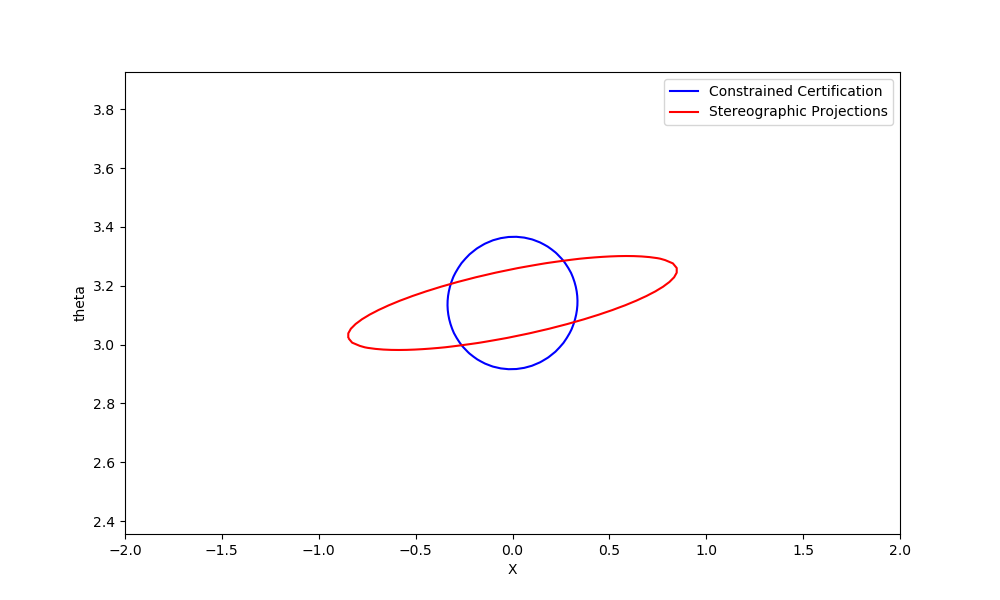

In [38]:
V_indeterminates = list(V.indeterminates())
V_ster_ind = list(V_ster.indeterminates())
# V_indeterminates

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
# img = ax.scatter(TR1[success_indices], XR1[success_indices], alpha=0.2)
# img = ax.scatter(TR1_old[success_indices_old], XR1_old[success_indices_old], alpha=0.02)

TRV = np.linspace(3*np.pi/4, 5*np.pi/4, 100)
XRV = np.linspace(-2, 2, 100)
TRV1, XRV1 = np.meshgrid(TRV, XRV)

Vplot = np.zeros_like(TRV1)
Vplot_ster = np.zeros_like(TRV1)

env = {}
env_2 = {}
for i in range(len(TRV1)):
    for j in range(len(TRV1[i])): 
        env[V_indeterminates[0]] = XRV1[i, j]
        env[V_indeterminates[1]] = np.sin(TRV1[i, j])
        env[V_indeterminates[2]] = np.cos(TRV1[i, j])
        env[V_indeterminates[3]] = 0
        env[V_indeterminates[4]] = 0
        Vplot[i,j] = V.Evaluate(env)
        env_2[V_ster_ind[0]] = XRV1[i, j]
        env_2[V_ster_ind[1]] = np.sin(TRV1[i, j]-np.pi)/(1 + np.cos(TRV1[i, j]-np.pi))
        env_2[V_ster_ind[2]] = 0
        env_2[V_ster_ind[3]] = 0
        Vplot_ster[i, j] = V_ster.Evaluate(env_2)

# Vplot_old = np.zeros_like(TRV1)
# env_old = {}
# for i in range(len(TRV1)):
#     for j in range(len(TRV1[i])): 
#         env_old[V_old_indeterminates[0]] = XRV1[i, j]
#         env_old[V_old_indeterminates[1]] = TRV1[i, j] - np.pi
#         env_old[V_old_indeterminates[2]] = 0
#         env_old[V_old_indeterminates[3]] = 0
#         Vplot_old[i, j] = V_old.Evaluate(env_old)
        
ax.contour(XRV1,TRV1, Vplot, levels=[567], colors='b')
ax.contour(XRV1,TRV1, Vplot_ster, levels=[0.951], colors='r')
ax.plot(0, np.pi, color='b', label='Constrained Certification')
ax.plot(0, np.pi, color='r', label='Stereographic Projections')
# ax.contour(TRV1,XRV1, Vplot_old, levels=[4005.9])
# ax.set_xlim(0, 2*np.pi)
# ax.set_ylim(-100, 100)
ax.set_ylabel("theta")
ax.set_xlabel("X")
ax.legend()